# Proekspert Data Science Assignment

**Ingvar Lukas**

My task was to combine images from the *multispectral images/* folder into a regular colored image. The resulting image should be similar to *sponges_RGB.bmp* found in the root directory.

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.misc import imread
from PIL import Image

# Inline figures
%matplotlib inline

# Modifying the default figure size.
matplotlib.rcParams['figure.figsize'] = [12, 10]

There are 2 helper functions:

In [2]:
'''
A simple function to list the filenames in a given directory.
'''
def list_filenames(directory):
    fnames = os.listdir(directory)
    fnames = [directory + fname for fname in fnames]
    return fnames

'''
This one is from stackoverflow to get the RGB weights corresponding to wavelengths in nm.
I have edited the original code, as it was 'slightly heavy on the red side'.
'''
def get_rgb_values(w):
    if w >= 380 and w < 440:
        #R = -(w - 440.) / (440. - 380.)
        R = 0.0
        G = 0.0
        B = 1.0
    elif w >= 440 and w < 490:
        R = 0.0
        G = (w - 440.) / (490. - 440.)
        B = 1.0
    elif w >= 490 and w < 510:
        R = 0.0
        G = 1.0
        B = -(w - 510.) / (510. - 490.)
    elif w >= 510 and w < 580:
        R = (w - 510.) / (580. - 510.)
        G = 1.0
        B = 0.0
    elif w >= 580 and w < 645:
        R = 1.0
        G = -(w - 645.) / (645. - 580.)
        B = 0.0
    elif w >= 645 and w <= 780:
        R = 1.0
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    
    return np.array([R,G,B])

# As we have 31 files, each one corresponding to a wavelength, 
# I'll generate a dict for indices in the range (0:31)
# and the corresponding wavelengths in nm.
wavelengths = {n: 400 + n * 10 for n in range(31)}


In [3]:
# List and sort the image filenames:
filelist = list_filenames('multispectral_images/')
filelist.sort()

In [4]:
# Just a check:
filelist

['multispectral_images/sponges_ms_01.png',
 'multispectral_images/sponges_ms_02.png',
 'multispectral_images/sponges_ms_03.png',
 'multispectral_images/sponges_ms_04.png',
 'multispectral_images/sponges_ms_05.png',
 'multispectral_images/sponges_ms_06.png',
 'multispectral_images/sponges_ms_07.png',
 'multispectral_images/sponges_ms_08.png',
 'multispectral_images/sponges_ms_09.png',
 'multispectral_images/sponges_ms_10.png',
 'multispectral_images/sponges_ms_11.png',
 'multispectral_images/sponges_ms_12.png',
 'multispectral_images/sponges_ms_13.png',
 'multispectral_images/sponges_ms_14.png',
 'multispectral_images/sponges_ms_15.png',
 'multispectral_images/sponges_ms_16.png',
 'multispectral_images/sponges_ms_17.png',
 'multispectral_images/sponges_ms_18.png',
 'multispectral_images/sponges_ms_19.png',
 'multispectral_images/sponges_ms_20.png',
 'multispectral_images/sponges_ms_21.png',
 'multispectral_images/sponges_ms_22.png',
 'multispectral_images/sponges_ms_23.png',
 'multispec

In [5]:
# I will concatenate all the image arrays on the third axis
# of this empty array:
img_array = np.empty([512, 512, 0], dtype=float)

In [6]:
# Looping through all the files, reading the image using imread
# and concatenating it to img_array
for file in filelist:
    pixel_array = imread(file)
    img_array = np.concatenate((img_array, pixel_array[:,:,None]), axis=2)

In [7]:
# Checking the shape of the array. It should be (512, 512, 31)
img_array.shape

(512, 512, 31)

In [8]:
# Here I will find the maximum intensity in the images
# and then normalise the image array by this maximum:
max_intensity = np.amax(img_array)
img_array = img_array / max_intensity

In [9]:
# preallocate empty arrays
R_array = np.empty([512, 512, 0])
G_array = np.empty([512, 512, 0])
B_array = np.empty([512, 512, 0])

# An array for all the RGB weights corresponding to each wavelength
weights = np.empty((0,3))

# Here I am looping through all the wavelengths and multiplying each image array
# corresponding to a wavelength with the respective RGB weight (for calculating
# the weighted mean).
for i in wavelengths:
    temp_R_array = np.empty([512, 512, 1])
    temp_G_array = np.empty([512, 512, 1])
    temp_B_array = np.empty([512, 512, 1])
    rgb = get_rgb_values(wavelengths[i])
    weights = np.vstack((weights, rgb))
    
    temp_R_array[:, :, 0] = rgb[0] * img_array[:,:,i]
    temp_G_array[:, :, 0] = rgb[1] * img_array[:,:,i]
    temp_B_array[:, :, 0] = rgb[2] * img_array[:,:,i]
    R_array = np.concatenate((R_array, temp_R_array), axis=2)
    G_array = np.concatenate((G_array, temp_G_array), axis=2)
    B_array = np.concatenate((B_array, temp_B_array), axis=2)

In [10]:
# Summing up all the RGB weights multiplied by intensity
R_sum = np.sum(R_array, axis=2)
G_sum = np.sum(G_array, axis=2)
B_sum = np.sum(B_array, axis=2)

# Summing up all weights
weights_sum = np.sum(weights, axis=0)

In [11]:
# Weighted arithmetic mean
R_mean = R_sum / weights_sum[0]
G_mean = G_sum / weights_sum[1]
B_mean = B_sum / weights_sum[2]

In [12]:
# Combining the weighted means to a single RGB array in uint8 format. Reference: 
# https://stackoverflow.com/questions/10443295/combine-3-separate-numpy-arrays-to-an-rgb-image-in-python

final_RGB = np.zeros((512,512,3), 'uint8')
final_RGB[:,:,0] = R_mean * 256
final_RGB[:,:,1] = G_mean * 256
final_RGB[:,:,2] = B_mean * 256

In [13]:
# RGB array to image
img = Image.fromarray(final_RGB)

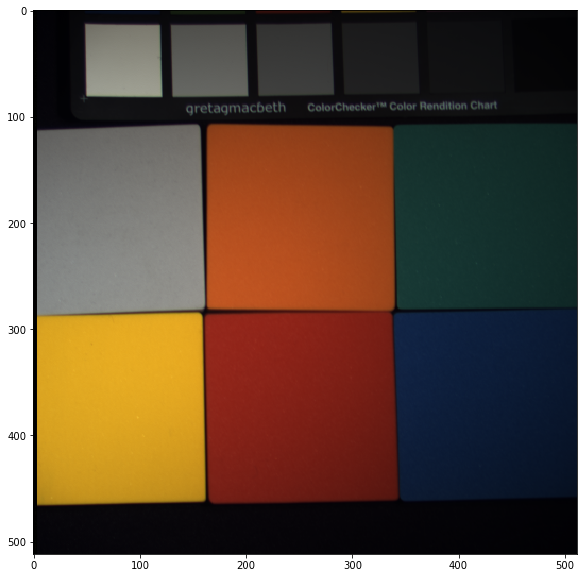

In [14]:
# Plot and save the obtained image
plt.imshow(img)
plt.savefig('sponges_obtained.png')

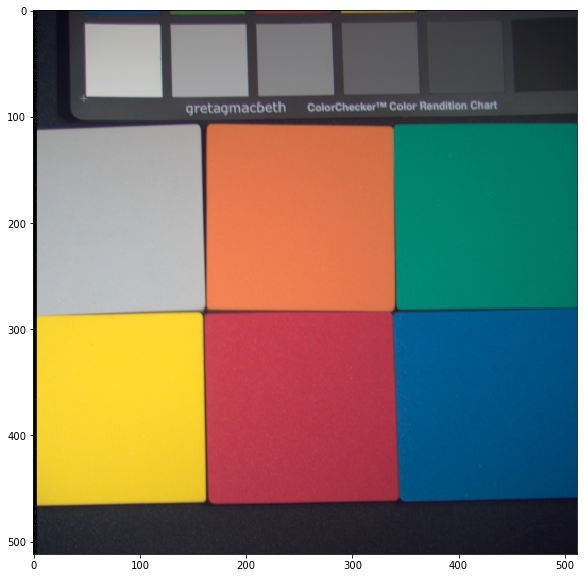

In [15]:
# Comparison with the original image
target_image = Image.open('sponges_RGB.bmp')
plt.imshow(target_image)